In [1]:
import numpy as np, pandas as pd
import zipfile
import random
import requests
from numpy import random as np_random
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import datetime
from math import e
import math
import copy
from sklearn.linear_model import LinearRegression
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


###Calibrate **kappa** and **sigma** based on historical volatlity of short rate

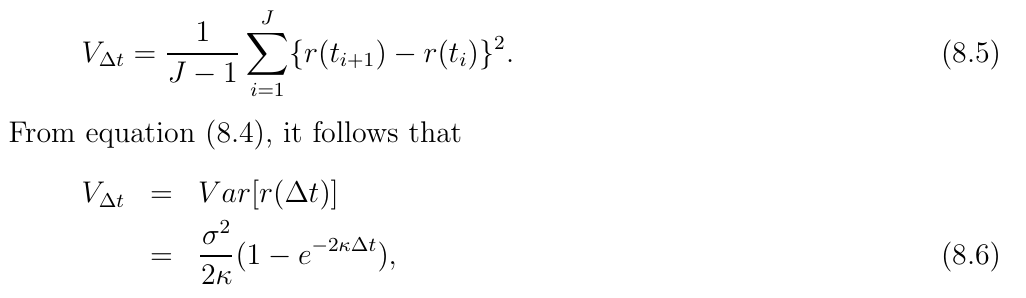

In [ ]:
#path = "/content/drive/MyDrive/Master thesis/Interest_rate_data/Euribor_week.xlsx"
path = "/content/drive/MyDrive/Master thesis/Interest_rate_data/Euribor_1M.xlsx"
sheet_name= "data"
df_short_rate =pd.read_excel(path,sheet_name)
df_short_rate = df_short_rate.set_index('date')
df_short_rate = df_short_rate / 100
df_short_rate

In [ ]:
def calc_v_t(delta_t):
  df_short_rate_copy = df_short_rate.copy()
  df_short_rate_copy["euribor_1m_t_lag"] = df_short_rate_copy["euribor"].shift(delta_t)
  df_short_rate_copy = df_short_rate_copy.dropna()
  a = df_short_rate_copy.loc[:,"euribor_1m_t_lag"]
  b = df_short_rate_copy.loc[:,"euribor"]

  v_t = 1 / (len(df_short_rate_copy) - 1) * np.sum((a-b)**2)
  return v_t

In [ ]:
delta_t_list = [1,5,10,20,40]
vt_list = []

for t in delta_t_list:
  vt = calc_v_t(t)
  vt_list.append(vt)

delta_t_vector = np.array(delta_t_list)
v_t_vector = np.array(vt_list)

In [ ]:
from scipy.optimize import least_squares

# Define the variance function from the formula
def variance_model(params, delta_t):
    sigma, kappa = params
    return (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * delta_t))

# Define residuals for least squares optimization
def residuals(params, delta_t, V_delta_t):
    return variance_model(params, delta_t) - V_delta_t

# Initial guesses for sigma and kappa
initial_guess = [0.01, 0.01]

# Solve the least squares problem
result = least_squares(residuals, initial_guess, args=(delta_t_vector, v_t_vector), bounds=([0, 0], [np.inf, np.inf]))

# Extract optimized parameters
sigma_opt, kappa_opt = result.x
print("Optimized σ:", sigma_opt)
print("Optimized κ:", kappa_opt)

Optimized σ: 0.005900677893437649
Optimized κ: 0.8612908966528063


###HJM Gaus Methodlogy => **Market price of risk**

#### **Step 0**: Import yield curve data and calculate forward rates

In [ ]:
#Import short rate data
path = "/content/drive/MyDrive/Master thesis/Interest_rate_data/yield_curve_data.xlsx"
sheet_name= "monthly"
yield_data =pd.read_excel(path,sheet_name)
yield_data = yield_data.set_index('date')
yield_data = yield_data / 100
yield_data

In [ ]:
forward_curve = yield_data.copy()
forward_curve["t_2"] = (yield_data["t_2"] * 2 - yield_data["t_1"] * 1)
forward_curve["t_3"] = (yield_data["t_3"] * 3 - yield_data["t_2"] * 2)
forward_curve["t_4"] = (yield_data["t_4"] * 4 - yield_data["t_3"] * 3)
forward_curve["t_5"] = (yield_data["t_5"] * 5 - yield_data["t_4"] * 4)
forward_curve["t_6"] = (yield_data["t_6"] * 6 - yield_data["t_5"] * 5)
forward_curve["t_7"] = (yield_data["t_7"] * 7 - yield_data["t_6"] * 6)
forward_curve["t_8"] = (yield_data["t_8"] * 8 - yield_data["t_7"] * 7)
forward_curve["t_9"] = (yield_data["t_9"] * 9 - yield_data["t_8"] * 8)
forward_curve["t_10"] = (yield_data["t_10"] * 10 - yield_data["t_9"] * 9)
forward_curve

####Plot

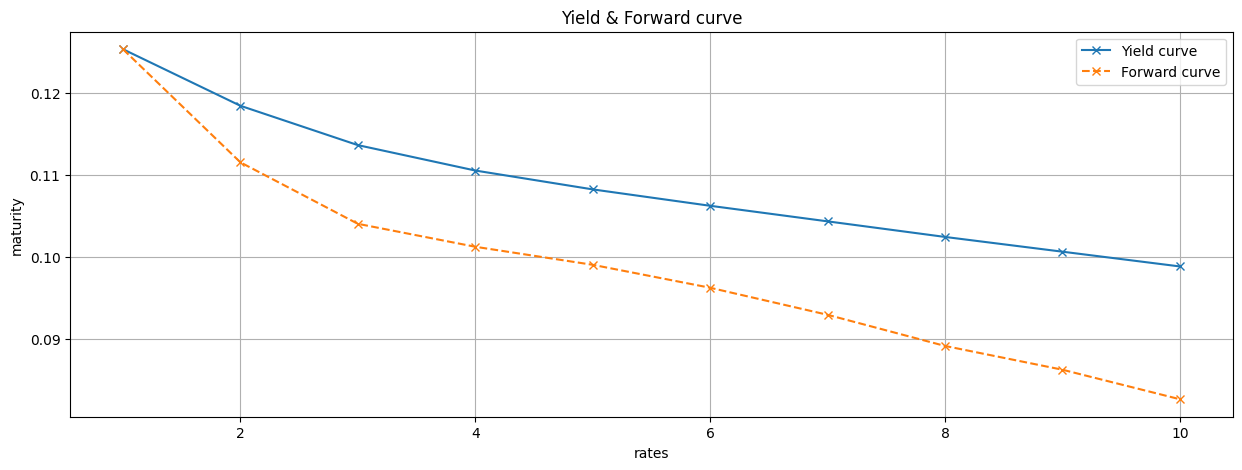

In [ ]:
x = np.arange(1, 11)
t= 105
# Plot
plt.figure(figsize=(15, 5))
plt.plot(x, yield_data.iloc[t, :], marker='x', linestyle='-', label=f'Yield curve')
plt.plot(x, forward_curve.iloc[t, :], marker='x', linestyle='--', label=f'Forward curve')

# Labels and title
plt.xlabel("rates")
plt.ylabel("maturity")
plt.title(f"Yield & Forward curve")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

#### **Step 1**: Calculate the forward rates and the difference

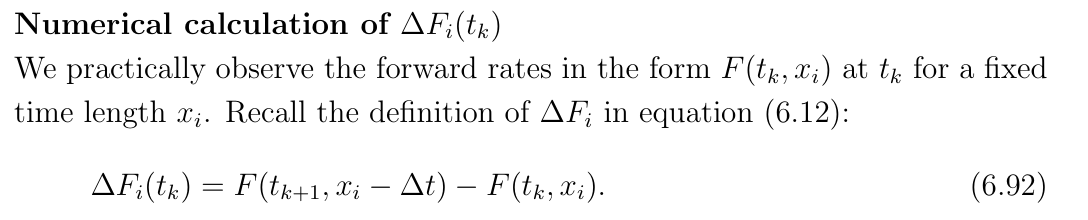

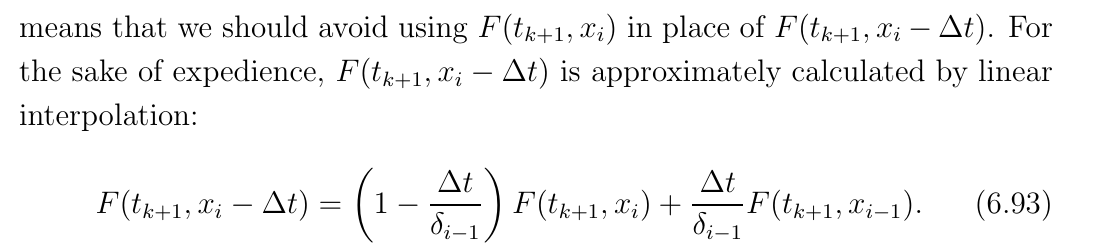

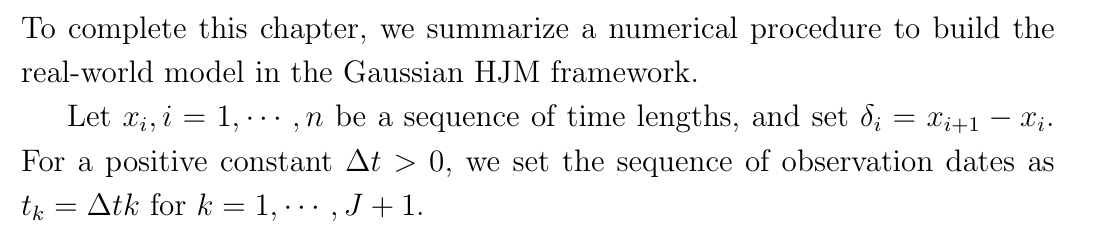

In [ ]:
def create_delta_F_tk(delta_t,delta_i, t_1, t_minus_1):
  df_Ftk = pd.DataFrame([])
  df_Ftk["Ftk_2"] = forward_curve[t_1]
  df_Ftk["Ftk+1_2_minus_delta_t_xi"] = df_Ftk["Ftk_2"].shift(-1)
  df_Ftk["Ftk+1_2_minus_delta_t_xi_minus_1"] = forward_curve[t_minus_1].shift(-1)
  df_Ftk["Ftk+1_2_minus_delta_t"] = (1- (delta_t/delta_i)) * df_Ftk["Ftk+1_2_minus_delta_t_xi"] + (delta_t/delta_i) * df_Ftk["Ftk+1_2_minus_delta_t_xi_minus_1"]
  df_Ftk[t_1] = df_Ftk["Ftk+1_2_minus_delta_t"] -  df_Ftk["Ftk_2"]

  return df_Ftk[t_1]

In [ ]:
#Example for xi = 2
delta_t = 0.1
delta_i = 1
t_list = ["t_2","t_3","t_4","t_5","t_6","t_7","t_8","t_9","t_10"]
t_minus_1_list = ["t_1","t_2","t_3","t_4","t_5","t_6","t_7","t_8","t_9"]
Ftk = pd.DataFrame()

for t in range(len(t_list)):
  Ftk = pd.concat([Ftk, create_delta_F_tk(delta_t, delta_i,t_list[t],t_minus_1_list[t])], axis=1)

Ftk = Ftk.dropna()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Ftk_scaled = scaler.fit_transform(Ftk)

In [ ]:
Ftk_cov_matrix = np.cov(Ftk_scaled, rowvar=False )
#Ftk_cov_matrix = Ftk_cov_matrix / delta_t

(9, 9)

#### **Step 2**: Perform a PCA on the covariance matrix to obtain p and the eigenvalue e

In [ ]:
from sklearn.decomposition import PCA

Ftk_cov_matrix = np.cov(Ftk_scaled, rowvar=False )

# Apply PCA
pca = PCA(n_components=9)  # Same number of components as maturities
pca.fit(Ftk_cov_matrix)

# Extract the first eigenvalue and eigenvector
rho = pca.explained_variance_[0]  # Largest eigenvalue (ρ)
eigenvector = pca.components_[0]   # Corresponding principal component
print(rho)

0.33514466528930065


#### **Step 3**: Least square minimization based on a constraint

In [ ]:
from scipy.optimize import minimize

n = 9  # Number of maturities
x = np.linspace(2, 10, n)  # Example maturities from 1 to 10

# Objective function
def objective(params):
    sigma, kappa = params
    return np.sum((rho * eigenvector - sigma * np.exp(-kappa * x)) ** 2)

# Constraint function: Norm-invariant condition
def constraint(params):
    sigma, kappa = params
    return rho**2 - np.sum(sigma**2 * np.exp(-2 * kappa * x))

# Initial guess for sigma and kappa
initial_guess = [0.01, 0.01]  # (sigma, kappa)

# Define constraint dictionary
constraint_dict = {'type': 'eq', 'fun': constraint}

#Define Bounds
bounds = [(None, None), (None, None)]  # Lower bound to avoid zero issues

# Solve optimization problem
result = minimize(objective, initial_guess, constraints=constraint_dict, bounds=bounds, method='SLSQP')

# Extract optimized parameters
sigma_opt, kappa_opt = result.x

print("Optimized Sigma:", sigma_opt*0.01)
print("Optimized Kappa:", kappa_opt*0.01)
print("Optimization Success:", result.success)

sigma = sigma_opt / 100
kappa = kappa_opt / 100

Optimized Sigma: 0.024339637590393096
Optimized Kappa: 0.010257537606856737
Optimization Success: True


In [ ]:
#Take the value from above
simga= 0.005900677893437649
kappa= 0.8612908966528063

#### **Step 4 - Step 6**: e_tilde, simga_0i_v_0i & beta

In [ ]:
n = 9  # Number of maturities
x_i = np.linspace(2, 10, n)

e_tilde = (sigma / rho) * np.exp(-kappa * x_i)
simga_0i_v_0i = (-sigma**2 / kappa) * np.exp(-kappa * x_i) * (1 - np.exp(-kappa * x_i))
beta = np.sum(simga_0i_v_0i * e_tilde)

print(beta)

-0.0019399648854206237


#### **Step 7**: Rolled Trend R

In [ ]:
#A Calculate E_H for every i (column) as the mean divided by delta_t
E_H = Ftk.mean(axis=0) / delta_t
#Calculate R as the sum of all inidivdiual E_H and e_tildes
R = np.sum(E_H.values * e_tilde)
R

-0.001809432754447599

#### **Step 8**: Calculate the market price of risk

In [ ]:
lambd = (R +beta) / rho
lambd

-0.011187400630804313

###Determine **theta**

In [19]:
lambd = -0.011187400630804313
kappa = 0.01
sigma = 0.01

In [20]:
path="/content/drive/MyDrive/Master thesis/Interest_rate_data/yield_svenson_parameter.xlsx"
sheet_name= "data"
df_parameters =pd.read_excel(path,sheet_name,index_col = 0)

In [21]:
# Estimate a continous function given Svensson parameters
beta0, beta1, beta2, beta3 = 1.17198,1.55754, 0.05323, 4.80134
tau1, tau2 = 0.65046, 12.29743

svensson_lambda_yield = lambda t: (((
    beta0 +
    beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1)) +
    beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1)) +
    beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2)))*0.01)
)

# Define the Svensson function using lambda
svensson_lambda = lambda t: np.exp(-((
    beta0 +
    beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1)) +
    beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1)) +
    beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2)))*0.01)*t
)


In [22]:
dt = 0.01
#Function to create a forward curve based on
def f0T(t,P0T):
    # time-step needed for differentiation
    dt = 0.01
    expr = - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    return expr

def hoo_lee_theta(T,P0T,sigma):
  theta = lambda t: (f0T(t+dt,P0T)-f0T(t-dt,P0T))/(2.0*dt) + sigma**2.0*t
  return theta

def hull_white_theta(T,P0T,sigma, kappa):
  theta = lambda t: (f0T(t+dt,P0T)-f0T(t-dt,P0T))/(2.0*dt) + kappa *f0T(t,P0T) + ((sigma**2)/2*kappa) * (1-np.exp(-2*kappa)*t)
  return theta

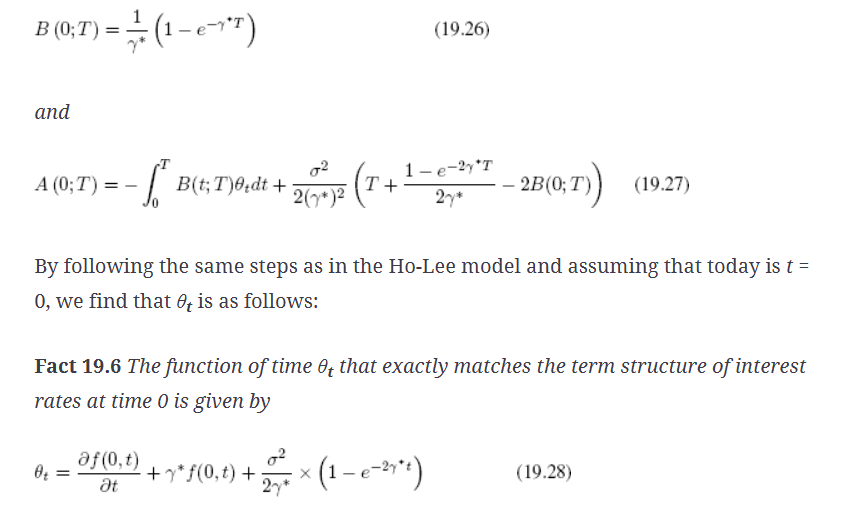

In [63]:
kappa = 0.01
sigma = 0.01

In [64]:
#Estimate bond prices based on this
from scipy.integrate import quad

def B_0_t(t, T, kappa):
  B = (1 / kappa) * ( 1- np.exp(-kappa * (T-t)))
  return B

B_t_T = lambda t, T: (1/kappa) * (1 - np.exp(-kappa * (T - t))) # Example definition

def A_0_t(t,T):
  integral, error = quad(lambda u: B_t_T(u, T) * theta(u), t, T)
  A = integral + ((sigma**2) / (2 * kappa**2)) * ((T-t) + (1-np.exp(-2*kappa*(T-t)))/(2 * kappa) - 2 * B_0_t(t,T,kappa))
  return A

T_range = np.linspace(0.1, 40, 100)  # Avoid T=0 to prevent division by zero
theta = hull_white_theta(40,svensson_lambda,sigma, kappa)
rates = []
for t in T_range:
  P = np.exp(A_0_t(0,t) - B_0_t(0,t,kappa) * 0.024)
  r = -np.log(P) / t
  rates.append(r)

rates = np.array(rates)

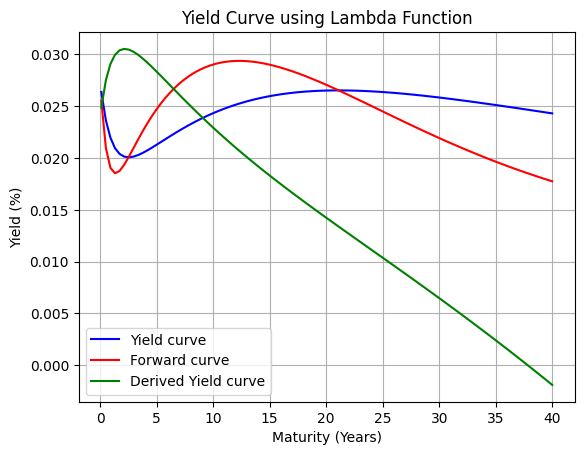

In [65]:
T_range = np.linspace(0.1, 40, 100)  # Avoid T=0 to prevent division by zero
forward_curve = f0T(T_range, svensson_lambda)
yield_curve = svensson_lambda_yield(T_range)
discount_factors = svensson_lambda(T_range)

plt.plot(T_range, yield_curve, label="Yield curve", color='b')
plt.plot(T_range, forward_curve, label="Forward curve", color='r')
plt.plot(T_range, rates,label="Derived Yield curve", color='g')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Yield Curve using Lambda Function")
plt.legend()
plt.grid()
plt.show()

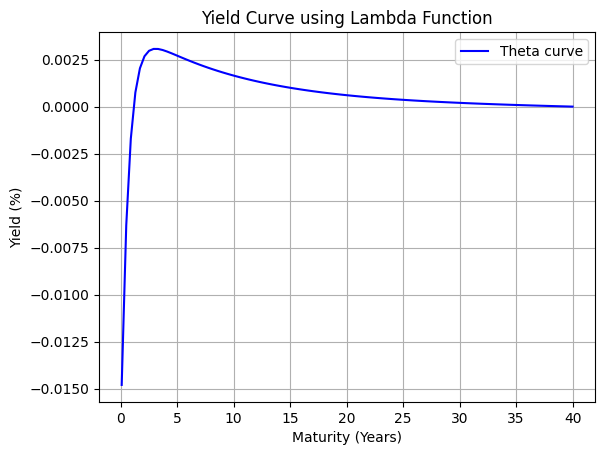

In [116]:
theta = hull_white_theta(40,svensson_lambda,sigma, kappa)

T_range = np.linspace(0.1, 40, 100)  # Avoid T=0 to prevent division by zero
theta_curve = theta(T_range)

plt.plot(T_range, theta_curve, label="Theta curve", color='b')
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.title("Yield Curve using Lambda Function")
plt.legend()
plt.grid()
plt.show()

##Determine theta

In [69]:
path="/content/drive/MyDrive/Master thesis/Interest_rate_data/yield_svenson_parameter.xlsx"
sheet_name= "data"
df_parameters =pd.read_excel(path,sheet_name,index_col = 0)

In [70]:
# Estimate a continous function given Svensson parameters
beta0, beta1, beta2, beta3 = 1.17198,1.55754, 0.05323, 4.80134
tau1, tau2 = 0.65046, 12.29743

In [83]:
# Define the Svensson function using lambda
def svensson_lambda_discount_factor(beta0,beta1,beta2,beta3, tau1, tau2, t):
  discount_factor = np.exp(-((
    beta0 +
    beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1)) +
    beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1)) +
    beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2)))*0.01)*t
)
  return discount_factor

def svensson_lambda_yield(beta0,beta1,beta2,beta3, tau1, tau2, t):
  rate = (((
    beta0 +
    beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1)) +
    beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1)) +
    beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2)))*0.01))
  return rate

#Define the forward yield curve function
def calc_forward_curve(t, delta):
  r_t = svensson_lambda_yield(beta0,beta1,beta2,beta3, tau1, tau2, t)  # r(0, t)
  r_t_plus_delta = svensson_lambda_yield(beta0,beta1,beta2,beta3, tau1, tau2, t + delta )  # r(0, t + delta)
  forward_rate = r_t + t * (r_t_plus_delta - r_t) / delta  # f(0, t)
  return forward_rate

In [81]:
# Parameters
delta = 0.000001  # Small step for finite difference approximation
sim_maturities = np.linspace(0.1, 10, 100)  # Maturities from 0.1 to 10 years

# Calculate forward curve
forward_curve = []
for t in sim_maturities:
    r_t = svensson_lambda_yield(beta0,beta1,beta2,beta3, tau1, tau2, t)  # r(0, t)
    r_t_plus_delta = svensson_lambda_yield(beta0,beta1,beta2,beta3, tau1, tau2, t+ delta)  # r(0, t + delta)
    forward_rate = r_t + t * (r_t_plus_delta - r_t) / delta  # f(0, t)
    forward_curve.append(forward_rate)

# Convert to numpy array
forward_curve = np.array(forward_curve)

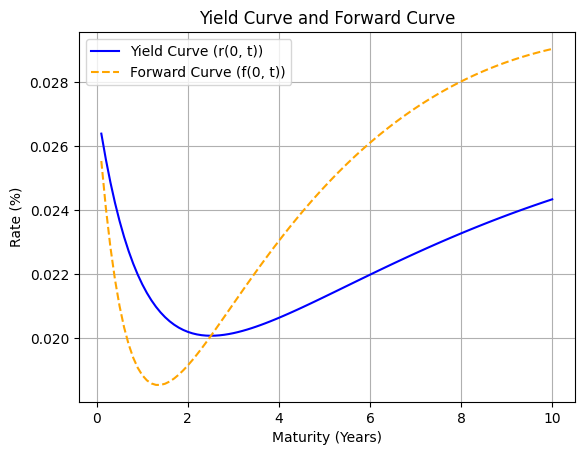

In [94]:
plt.plot(sim_maturities, [svensson_lambda_yield(beta0,beta1,beta2,beta3, tau1, tau2, t) for t in sim_maturities], label="Yield Curve (r(0, t))", color="blue")
plt.plot(sim_maturities, forward_curve, label="Forward Curve (f(0, t))", color="orange", linestyle="--")
plt.title("Yield Curve and Forward Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Rate (%)")
plt.legend()
plt.grid()
plt.show()

Calculate theta

In [197]:
# Parameters
kappa = 0.2
sigma = 0.02  # Volatility of the short rate
delta = 0.001  # Small step for finite difference approximation
times = np.linspace(0.1, 10, 100)  # Time points for which to calculate theta

theta_values = []
for t in times:
    f_t = calc_forward_curve(t, delta)  # f(0, t)
    f_t_plus_delta = calc_forward_curve(t + delta, delta)  # f(0, t + delta)
    derivative_term = (f_t_plus_delta - f_t) / delta  # Finite difference approximation
    #theta_t = derivative_term + sigma**2 * t  # Apply formula
    #theta_t = derivative_term + kappa * f_t + (sigma**2/2*kappa) * (1-np.exp(-2*kappa)*t)
    theta_t = derivative_term + kappa * f_t + (sigma**2/(2*kappa)) * (1-np.exp(-2*kappa*t))
    theta_values.append(theta_t)

# Convert to numpy array
theta_values = np.array(theta_values)

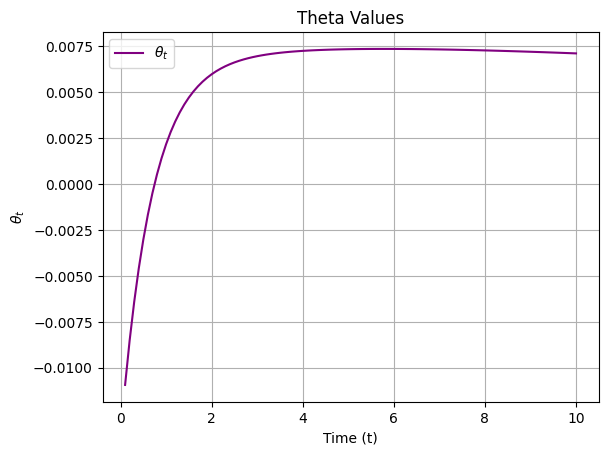

In [191]:
# Plot theta_t values
plt.plot(times, theta_values, label=r'$\theta_t$', color='purple')
plt.title('Theta Values')
plt.xlabel('Time (t)')
plt.ylabel(r'$\theta_t$')
plt.grid()
plt.legend()
plt.show()

#####Bond Prices in Hull White

In [ ]:
def B_t_T(t, T):
  B = ((1)/kappa) * (1-np.exp(-kappa*(T-t)))
  return B

#Calculate B values
times = np.linspace(0.1, 10, 100)  # Time points for which to calculate theta

B_list = []
for t in times:
  b_value = B_t_T(0, t)
  B_list.append(b_value)

b_values = np.array(B_list)
b_values

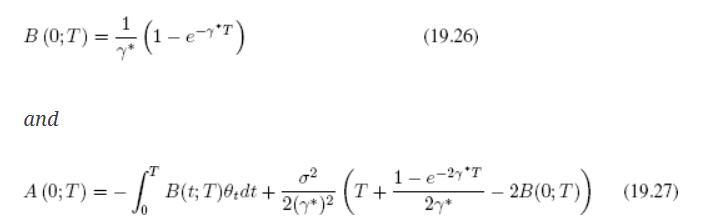

In [193]:
def integral_approximation(times, theta_values,b_values, T, delta):
    relevant_b_value = b_values[times < T]
    relevant_theta_value = theta_values[times < T]
    n = len(relevant_theta_value)
    j_indices = np.arange(1, n + 1)  # Create indices 1, 2, ..., n
    T_minus_J_theta = T - j_indices * delta    # Compute (T - jδ)
    approximation = np.sum(relevant_theta_value * relevant_b_value * delta)  # Apply summation formula
    return approximation

In [206]:
hull_white = []
test_times = np.linspace(0.1, 10, 100)

r0 = 0.0265
for t in test_times:
  integral_part = integral_approximation(times, theta_values,b_values, t, 0.1)
  B =  B_t_T(0, t)
  A = -integral_part + ((sigma**2) / (2*(kappa**2))) * (t + ((1-np.exp(-2*kappa*t))/(2*kappa))-2*B)
  Z = np.exp(A - B * r0)
  r = -np.log(Z) / t
  hull_white.append(r)

hull_white_vector = np.array(hull_white)


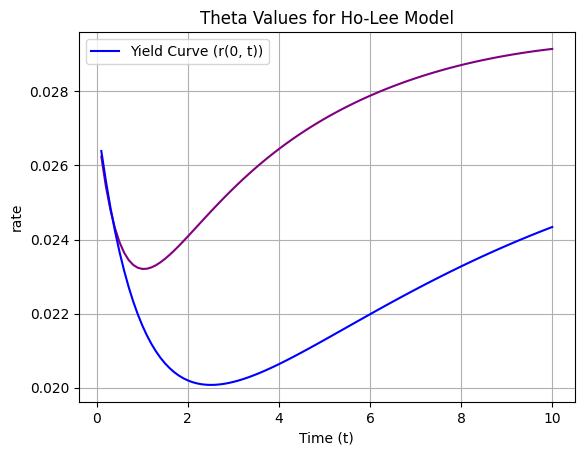

In [207]:
# Plot values
#plt.scatter(original_maturities, yield_points, color='red', label='Original Data')  # Original points
plt.plot(times, hull_white_vector, color='purple')
plt.plot(sim_maturities, [svensson_lambda_yield(beta0,beta1,beta2,beta3, tau1, tau2, t) for t in sim_maturities], label="Yield Curve (r(0, t))", color="blue")
plt.title('Theta Values for Ho-Lee Model')
plt.xlabel('Time (t)')
plt.ylabel('rate')
plt.grid()
plt.legend()
plt.show()

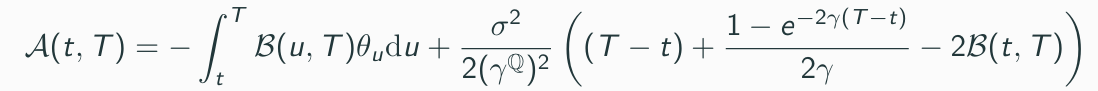

#####Bond Prices in Hoo Lee

In [131]:
def integral_approximation(times, theta_values, T, delta):
    relevant_theta_value = theta_values[times < T]
    n = len(relevant_theta_value)
    j_indices = np.arange(1, n + 1)  # Create indices 1, 2, ..., n
    T_minus_J_theta = T - j_indices * delta    # Compute (T - jδ)
    approximation = np.sum(relevant_theta_value * T_minus_J_theta * delta)  # Apply summation formula
    return approximation

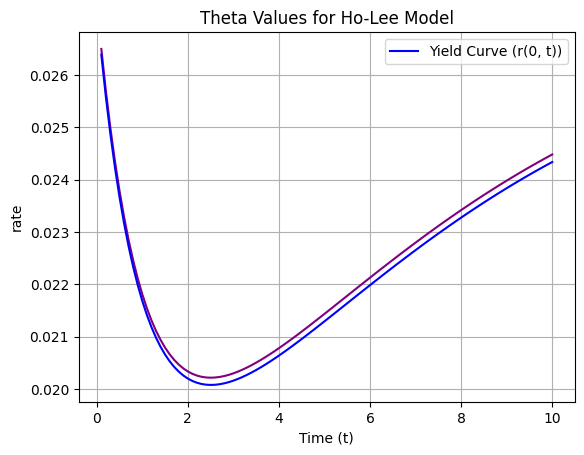

In [132]:
ho_lee = []
test_times = np.linspace(0.1, 10, 100)

r0 = 0.0265
for t in test_times:
  integral_part = integral_approximation(times, theta_values, t, 0.1)
  A = -integral_part + (t**3 / 6) * sigma**2
  Z = np.exp(A - t * r0)
  r = -np.log(Z) / t
  ho_lee.append(r)

ho_lee_vector = np.array(ho_lee)
# Plot values
#plt.scatter(original_maturities, yield_points, color='red', label='Original Data')  # Original points
plt.plot(times, ho_lee_vector, color='purple')
plt.plot(sim_maturities, [svensson_lambda_yield(beta0,beta1,beta2,beta3, tau1, tau2, t) for t in sim_maturities], label="Yield Curve (r(0, t))", color="blue")
plt.title('Theta Values for Ho-Lee Model')
plt.xlabel('Time (t)')
plt.ylabel('rate')
plt.grid()
plt.legend()
plt.show()


